## Skin Cancer Classification | Transfer Learning | XAI

#### Load image dataset


This python files set the path for the folders where train and test images are stored, inspect the data (i.e. number of images), create dataframe using path to each image and theor labels.

In [ ]:
pip install scikit-plot tensorflow-hub tensorflow_addons -q vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Import required packages
import os
import glob
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from vit_keras import vit
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# In case running with Google colab mount the drive to access the dataset uploaded on drive (If running in local no need to run this step)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to dataset - data is stored in folder named data/train and data/test
# In case running on local system, you can define path to the folder where data is stored
path_train = '/content/drive/MyDrive/Colab Notebooks/8013/data/train/'
path_test = '/content/drive/MyDrive/Colab Notebooks/8013/data/test/'

In [ ]:
# Use glob to get path for images withtin folders
train_images = glob.glob(f"{path_train}**/*.jpg")
test_images = glob.glob(f"{path_test}**/*.jpg")

In [ ]:
# Check the size of training and testing data(images)
train_samples = len(train_images)
test_samples = len(test_images)

print(f'train samples count: {train_samples}')
print(f'test samples count: {test_samples}')

train samples count: 2637
test samples count: 660


In [ ]:
# Create dataframe to store path to each image along with label

# generate labels
trian_labels = [_.split('/')[-2:][0] for _ in train_images]
test_labels = [_.split('/')[-2:][0] for _ in test_images]


train_df = pd.DataFrame({
    'image_path': train_images,
    'label': trian_labels
})

test_df = pd.DataFrame({
    'image_path': test_images,
    'label': test_labels
})

# Generate encoded labels malignant - 1, benign - 0
train_df['label_encoded'] = train_df.apply(lambda row: 1 if row.label == 'malignant' else 0, axis=1)
test_df['label_encoded'] = test_df.apply(lambda row: 1 if row.label == 'malignant' else 0, axis=1)

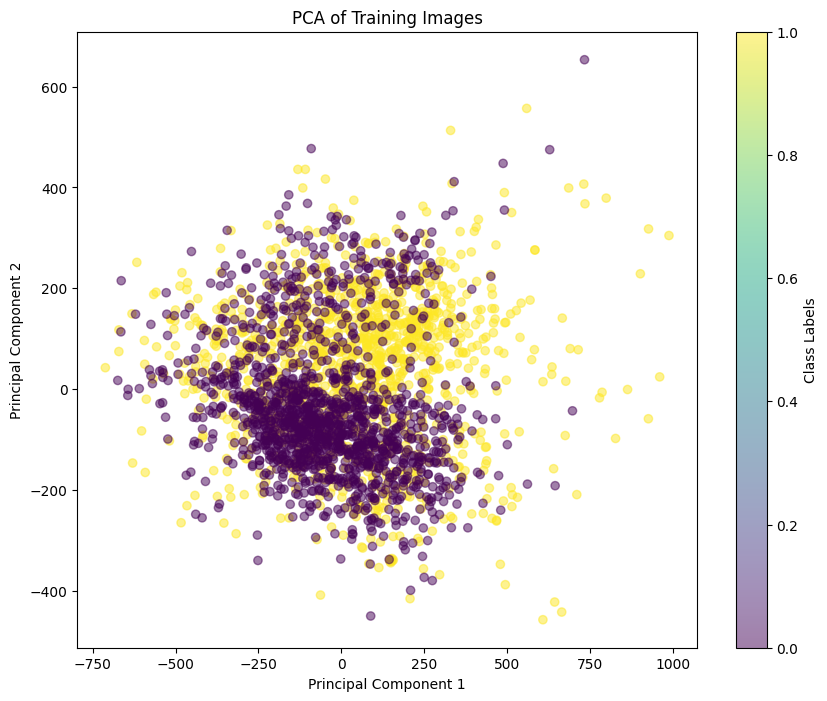

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_preprocess_images(image_paths, resize_dim=(224, 224)):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        if resize_dim is not None:
            image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)
        images.append(image)
    return np.array(images)

# Load images from the dataframe
image_paths = train_df['image_path'].values 
train_images = load_preprocess_images(image_paths)

# Flatten the images
num_images, height, width, channels = train_images.shape
flattened_images = train_images.reshape((num_images, height * width * channels))

# Standardize the data
scaler = StandardScaler()
flattened_images_standardized = scaler.fit_transform(flattened_images)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_images_standardized)

# Extract labels for coloring the scatter plot
labels = train_df['label_encoded'].values  

# Scatter plot of the PCA result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, alpha=0.5, cmap='viridis')
plt.title('PCA of Training Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Class Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


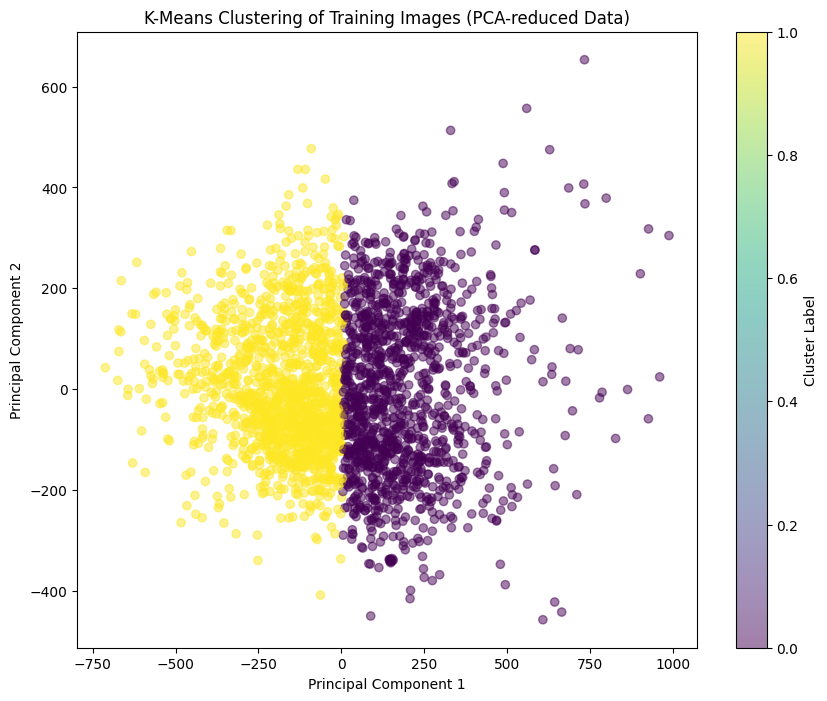

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(pca_result)

# Plot the clustered data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, alpha=0.5, cmap='viridis')
plt.title('K-Means Clustering of Training Images (PCA-reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()